# Instance segmentation with PyTorch, Detectron2 on a local machine
Finetune a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model on images from your project. After running this notebook, you will have a model that can outline the silhouettes of all fish within an image.

You'll use Azure Machine Learning to: 

- Initialize a workspace 
- Define a training environment
- Train a model locally
- Register your model
- Generate predictions locally

## Prerequisities

- If you are using an Azure Machine Learning Compute VM, your environment already meets these prerequisites. Otherwise, go through the [configuration notebook](../../../../../configuration.ipynb) to install the Azure Machine Learning Python SDK and [create an Azure ML Workspace](https://docs.microsoft.com/azure/machine-learning/how-to-manage-workspace#create-a-workspace). You also need detectron2, pycocotools-2.0.0, torchvision >= 0.5.0 and torch >= 1.4.0 (Based on CUDA 10.0).

### Import resources

Run the cell below to import required tools, if you're running for the first time this can take 5-10 minutes. 

In [1]:
import sys
!{sys.executable} -m pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!{sys.executable} -m pip install pycocotools>=2.0.1
!{sys.executable} -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-kdc8vma6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-kdc8vma6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=282762 sha256=f842446b5308e56a33bc721cd8cce3117126e960ea7e9f1067daf018aa9fb60c
  Stored in directory: /tmp/pip-ephem-wheel-cache-k27vsp70/wheels/25/c1/63/8bee2969883497d2785c9bdbe4e89cae5efc59521553d528bf
Successfully built pycocotools
ERROR: detectron2 0.2.1+cu101 has requirement pycocotools>=2.0.1, but you'll have pycocotools 2.0 which is incompatible.
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
Processing /home/azureuser/.cach

  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [2]:
# Check core SDK version number, check other dependencies
import azureml.core
from tqdm import tqdm
import json
import os
print("SDK version:", azureml.core.VERSION)

SDK version: 1.13.0


## Diagnostics

Opt-in diagnostics for better experience, quality, and security in future releases.

In [3]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


## Initialize a workspace

Initialize a [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`, using the [from_config()](https://docs.microsoft.com/python/api/azureml-core/azureml.core.workspace(class)?view=azure-ml-py#from-config-path-none--auth-none---logger-none---file-name-none-) method.

The config file can be downloaded from the Azure Studio - Change Subscription section found in the top right corner of any page. Ensure the downloaded config.file is loaded into the notebooks section within aml. 

In [ ]:
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

### Create an experiment

Things you need to enter for your dataset in the ##-##-HERE secions:

* experiment_name = 'name your experiment e.g. bruvnet'
* blob_datastore_name = 'the name of the datastore you created earlier'
* account_name = "the name of your Azure storage account where images are stored"
* container_name = "the name of the container in your storage account"
* sas_key= "generate SAS key with read-write-delete permissions"

In [5]:
from azureml.core import Experiment

experiment_name = 'EXPERIMENT-NAME-HERE' #name experiment here
experiment = Experiment(ws, name=experiment_name)

In [6]:
from msrest.exceptions import HttpOperationError


blob_datastore_name='DATASTORE-NAME-HERE'# Name of data datastore
account_name=os.getenv("BLOB_ACCOUNTNAME_62", "ACCOUNT-NAME-HERE") # Storage account name
container_name=os.getenv("BLOB_CONTAINER_62", "CONTAINER-NAME-HERE") # Name of Azure blob container
sas_key=os.getenv("BLOB_ACCOUNT_KEY_62", "SAS-KEY-HERE") # Storage account key



try:
    blob_datastore = Datastore.get(ws, blob_datastore_name)
    print("Found Blob Datastore with name: %s" % blob_datastore_name)
except HttpOperationError:
    blob_datastore = Datastore.register_azure_blob_container(
        workspace=ws,
        datastore_name=blob_datastore_name,
        account_name=account_name, # Storage account name
        container_name=container_name, # Name of Azure blob container
        sas_token=sas_key) # Storage account key
    print("Registered blob datastore with name: %s" % blob_datastore_name)

Found Blob Datastore with name: bruvstg


In [7]:
from azureml.core import Workspace, Datastore, Dataset


# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(blob_datastore, '*.*')]

bruv_ds = Dataset.File.from_files(path=datastore_paths)

In [10]:
mount_context = bruv_ds.mount()

In [11]:
mount_context.start()

### Add Classes

Add all species names in the dataset here. This can be confirmed by opening the .json file for BRUVNet_Master and viewing species listed at the bottom. Ensure correct spelling. 

In [12]:
class_labels = ['Ambassis spp.','Melanotaenia splendida inornata','Melanotaenia nigrans','Mogurnda mogurnda','Leiopotherapon unicolor','Pseudomugilidae spp., Denariusa australis']

In [13]:
os.listdir(mount_context.mount_point)

['1.jpg',
 '10.jpg',
 '100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg',
 '108.jpg',
 '109.jpg',
 '11.jpg',
 '110.jpg',
 '111.jpg',
 '112.jpg',
 '113.jpg',
 '114.jpg',
 '115.jpg',
 '116.jpg',
 '117.jpg',
 '118.jpg',
 '119.jpg',
 '12.jpg',
 '120.jpg',
 '121.jpg',
 '122.jpg',
 '123.jpg',
 '124.jpg',
 '125.jpg',
 '126.jpg',
 '127.jpg',
 '128.jpg',
 '129.jpg',
 '13.jpg',
 '130.jpg',
 '131.jpg',
 '132.jpg',
 '133.jpg',
 '134.jpg',
 '135.jpg',
 '136.jpg',
 '137.jpg',
 '138.jpg',
 '139.jpg',
 '14.jpg',
 '140.jpg',
 '141.jpg',
 '142.jpg',
 '143.jpg',
 '144.jpg',
 '145.jpg',
 '146.jpg',
 '147.jpg',
 '148.jpg',
 '149.jpg',
 '15.jpg',
 '150.jpg',
 '151.jpg',
 '152.jpg',
 '153.jpg',
 '154.jpg',
 '155.jpg',
 '156.jpg',
 '157.jpg',
 '158.jpg',
 '159.jpg',
 '16.jpg',
 '160.jpg',
 '161.jpg',
 '162.jpg',
 '163.jpg',
 '164.jpg',
 '165.jpg',
 '166.jpg',
 '167.jpg',
 '168.jpg',
 '169.jpg',
 '17.jpg',
 '170.jpg',
 '171.jpg',
 '172.jpg',
 '173.jpg',
 '174.jpg',
 '

### Register BRUVNet COCO Dataset

Update the following:
* register_coco_instances("dataset name")
* os.path.join("name of .json file with labels") - name can be confirmed in cell above by scrolling to bottom

* bruvnet_metadata = "dataset name"
* dataset_dicts = "dataset name"

In [14]:
# register coco data set
from detectron2.data.datasets import register_coco_instances
register_coco_instances("", {}, os.path.join(mount_context.mount_point, ""), mount_context.mount_point)

In [16]:
from detectron2.data import DatasetCatalog, MetadataCatalog
bruvnet_meta = MetadataCatalog.get("") #add dataset name
dataset_dicts = DatasetCatalog.get("") #add dataset name

In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer

### Visualise annotations

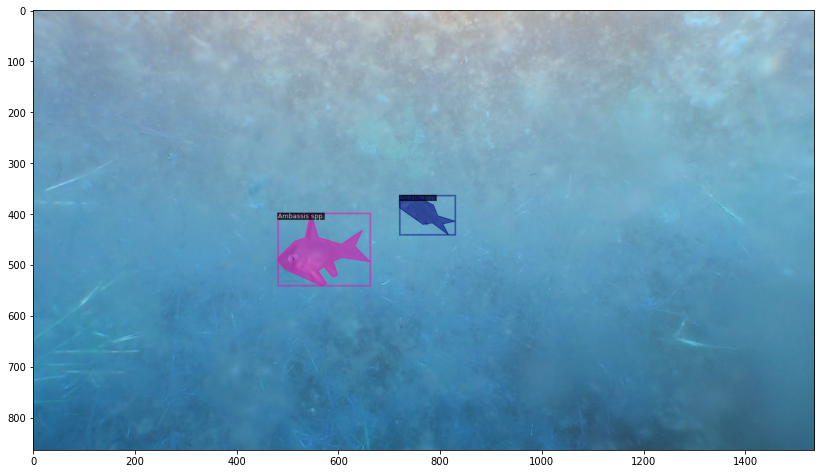

In [21]:
import random

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=bruvnet_meta, scale=0.8)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

### Load Base Models

This may take several minutes. 

In [22]:
#  download base models
os.makedirs('configs', exist_ok = True)
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/master/configs/Base-RCNN-FPN.yaml -O Base-RCNN-FPN.yaml
!wget https://raw.githubusercontent.com/facebookresearch/detectron2/master/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml -O configs/mask_rcnn_R_50_FPN_3x.yaml

--2020-10-15 02:40:16--  https://raw.githubusercontent.com/facebookresearch/detectron2/master/configs/Base-RCNN-FPN.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.28.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.28.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318 (1.3K) [text/plain]
Saving to: ‘Base-RCNN-FPN.yaml’

Base-RCNN-FPN.yaml  100%[===================>]   1.29K  --.-KB/s    in 0s      

2020-10-15 02:40:16 (93.8 MB/s) - ‘Base-RCNN-FPN.yaml’ saved [1318/1318]

--2020-10-15 02:40:17--  https://raw.githubusercontent.com/facebookresearch/detectron2/master/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.28.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.28.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192 [text/plain]
Saving to: ‘conf

## Build Model configs

The change the number of iterations and how long the model will train for, adjust:
* cfg.SOLVER.MAX_ITER = 

Indicate your training dataset name:
* cfg.DATASETS.TRAIN = 

In [23]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("configs/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_labels) # dynamically work out number of classes
# uncomment for semantic segmentation
#cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(class_labels) # dynamically work out number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/15 02:41:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/15 02:41:14 d2.data.datasets.coco]: Loaded 827 images in COCO format from /tmp/tmp2px1eysa/BRUVNet_Master.json
[10/15 02:41:14 d2.data.build]: Removed 180 images with no usable annotations. 647 images left.
[10/15 02:41:14 d2.data.build]: Distribution of instances among all 7 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| Ambassis spp. | 1428         | Melanotaeni.. | 2074         | Melanotaeni.. | 43           |
| Mogurnda mo.. | 21           | Pseudomugil.. | 2            | Leiopothera.. | 12           |
| Denariusa a.. | 1            |               |              |               |              |
|     total     | 3581         |               |              |               |              |
[10/15 02:41:14 d2.data.common]: Serializing 647 elements to byte tensors and concatenating them all ...
[10/15 02:41:14 d2.data.common]:

WARNING - Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
WARNING - Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
WARNING - Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
WARNING - Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
WARNING - Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80

[10/15 02:41:49 d2.engine.train_loop]: Starting training from iteration 0
[10/15 02:42:22 d2.utils.events]:  eta: 0:25:48  iter: 19  total_loss: 3.737  loss_cls: 2.056  loss_box_reg: 0.717  loss_mask: 0.692  loss_rpn_cls: 0.203  loss_rpn_loc: 0.038  time: 1.5273  data_time: 0.0294  lr: 0.000005  max_mem: 2672M
[10/15 02:42:52 d2.utils.events]:  eta: 0:25:12  iter: 39  total_loss: 3.498  loss_cls: 1.894  loss_box_reg: 0.724  loss_mask: 0.690  loss_rpn_cls: 0.099  loss_rpn_loc: 0.021  time: 1.5236  data_time: 0.0044  lr: 0.000010  max_mem: 2672M
[10/15 02:43:23 d2.utils.events]:  eta: 0:24:43  iter: 59  total_loss: 3.150  loss_cls: 1.633  loss_box_reg: 0.685  loss_mask: 0.686  loss_rpn_cls: 0.173  loss_rpn_loc: 0.029  time: 1.5239  data_time: 0.0041  lr: 0.000015  max_mem: 2672M
[10/15 02:43:53 d2.utils.events]:  eta: 0:24:10  iter: 79  total_loss: 2.891  loss_cls: 1.340  loss_box_reg: 0.785  loss_mask: 0.678  loss_rpn_cls: 0.116  loss_rpn_loc: 0.028  time: 1.5229  data_time: 0.0045  lr:

[10/15 02:59:04 d2.utils.events]:  eta: 0:08:25  iter: 679  total_loss: 0.985  loss_cls: 0.233  loss_box_reg: 0.458  loss_mask: 0.236  loss_rpn_cls: 0.009  loss_rpn_loc: 0.017  time: 1.5182  data_time: 0.0055  lr: 0.000170  max_mem: 2672M
[10/15 02:59:35 d2.utils.events]:  eta: 0:07:53  iter: 699  total_loss: 1.105  loss_cls: 0.276  loss_box_reg: 0.503  loss_mask: 0.256  loss_rpn_cls: 0.011  loss_rpn_loc: 0.027  time: 1.5189  data_time: 0.0047  lr: 0.000175  max_mem: 2672M
[10/15 03:00:05 d2.utils.events]:  eta: 0:07:22  iter: 719  total_loss: 0.991  loss_cls: 0.215  loss_box_reg: 0.454  loss_mask: 0.250  loss_rpn_cls: 0.008  loss_rpn_loc: 0.026  time: 1.5189  data_time: 0.0046  lr: 0.000180  max_mem: 2672M
[10/15 03:00:36 d2.utils.events]:  eta: 0:06:50  iter: 739  total_loss: 0.984  loss_cls: 0.238  loss_box_reg: 0.478  loss_mask: 0.243  loss_rpn_cls: 0.008  loss_rpn_loc: 0.018  time: 1.5190  data_time: 0.0044  lr: 0.000185  max_mem: 2672M
[10/15 03:01:07 d2.utils.events]:  eta: 0:06

Indicate name of test dataset (same above):
* cfg.DATASETS.TEST = 

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("", )
predictor = DefaultPredictor(cfg)

### Visualise Preditions

Make a prediction using the newly trained model on an image in your training dataset. Images are randomnly selected from your dataset.  

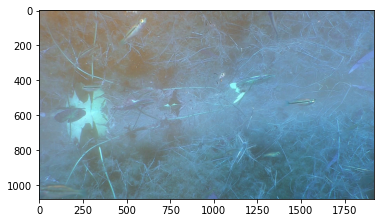

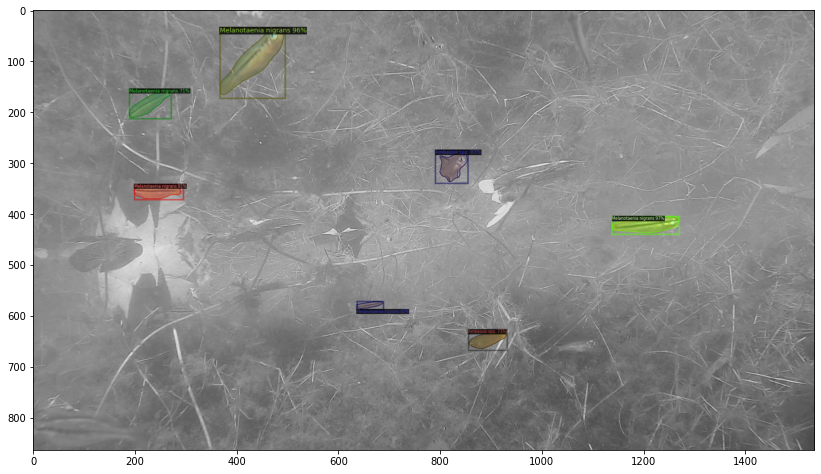

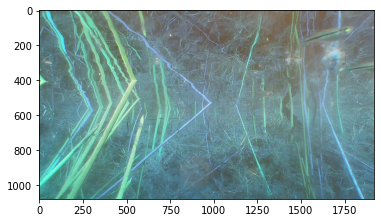

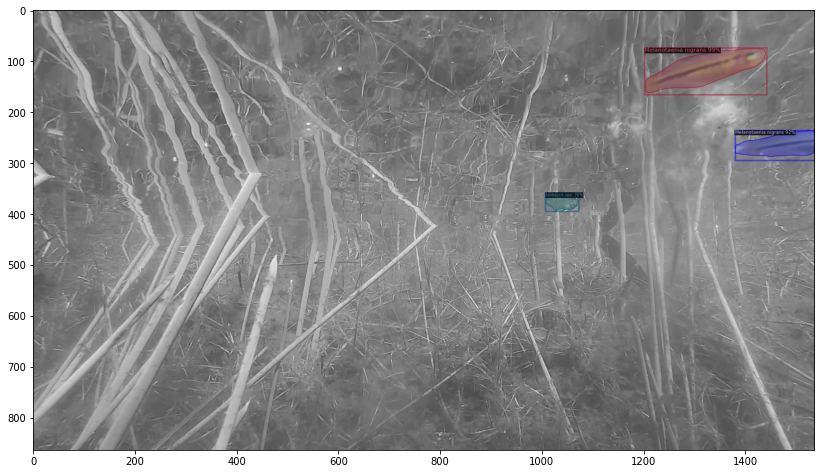

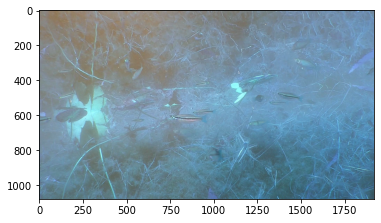

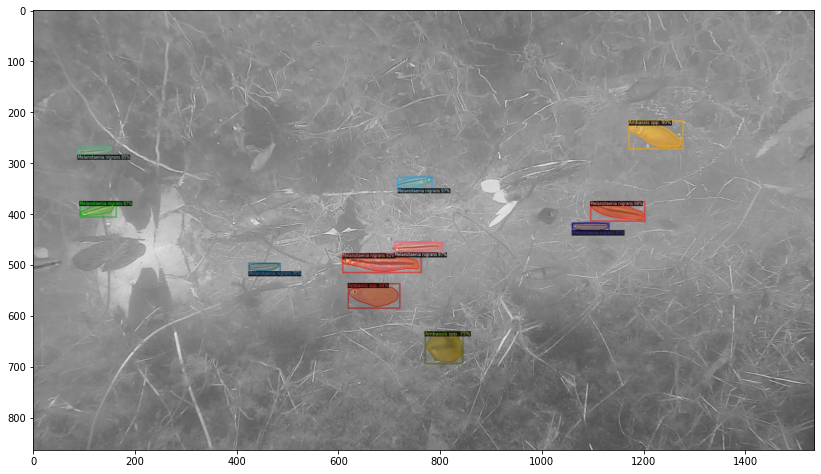

In [26]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    plt.imshow(im)
    plt.show()
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=bruvnet_meta,
                   scale=0.8,
                  instance_mode=ColorMode.IMAGE_BW ) # set unsegmented pixels to BW
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

### View Model Performance

Add dataset name to:
* evaluator = ""
* val_loader = ""

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bruvnet", cfg, False, output_dir="./output/COCO_evaluator") #add dataset name
val_loader = build_detection_test_loader(cfg, "bruvnet") #add dataset name
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[10/09 04:06:37 d2.data.datasets.coco]: Loaded 515 images in COCO format from /tmp/tmp5_owek2u/BRUVNet_Master.json
[10/09 04:06:37 d2.data.common]: Serializing 515 elements to byte tensors and concatenating them all ...
[10/09 04:06:37 d2.data.common]: Serialized dataset takes 0.25 MiB
[10/09 04:06:37 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/09 04:06:37 d2.evaluation.evaluator]: Start inference on 515 images
[10/09 04:06:46 d2.evaluation.evaluator]: Inference done 11/515. 0.4934 s / img. ETA=0:07:05
[10/09 04:06:51 d2.evaluation.evaluator]: Inference done 17/515. 0.4975 s / img. ETA=0:07:08
[10/09 04:06:56 d2.evaluation.evaluator]: Inference done 23/515. 0.4993 s / img. ETA=0:07:05
[10/09 04:07:02 d2.evaluation.evaluator]: Inference done 30/515. 0.4907 s / img. ETA=0:06:43
[10/09 04:07:07 d2.evaluation.evaluator]: Inference done 36/515. 0.4910 s / img. ETA=0:06:39
[10/09 04:07:1

OrderedDict([('bbox',
              {'AP': 4.283125231089485,
               'AP50': 14.18831322382712,
               'AP75': 1.2440762804927121,
               'APs': 2.0198019801980194,
               'APm': 2.506735309458956,
               'APl': 5.813009636445432,
               'AP-Ambassis spp.': 13.886070143714122,
               'AP-Melanotaenia nigrans': 8.067315574504546,
               'AP-Melanotaenia splendida inornata': 0.28001913366477554,
               'AP-Mogurnda mogurnda': 3.4653465346534658,
               'AP-Pseudomugilidae spp.': 0.0,
               'AP-Leiopotherapon unicolor': 0.0}),
             ('segm',
              {'AP': 7.549503908911466,
               'AP50': 17.42721985577578,
               'AP75': 4.4302751250723,
               'APs': 0.4590459045904591,
               'APm': 1.8187106231569863,
               'APl': 13.122467745839996,
               'AP-Ambassis spp.': 23.667239170580263,
               'AP-Melanotaenia nigrans': 17.24981075466